In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from windrose import WindroseAxes
from windrose import plot_windrose
import matplotlib.cm as cm
from PIL import Image
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from fbprophet import Prophet
import math



df = pd.read_csv('preprocessed_data_15_weeks.csv')
df.ds= pd.to_datetime(df.ds)

In [2]:
df.head()

,ds,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e
0,2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667
1,2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000
2,2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333
3,2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000
4,2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667


In [3]:
#a_hum=(6.112*r_hum*math.exp((17.62*temp)/(243.12+temp)))/(461.5*(temp+273.15))
#df['a_hum'] = df.apply(lambda row: (6.112*row['r_hum']*math.exp((17.62*row['temp'])/(243.12+row['temp'])))/(461.5*(row['temp']+273.15)))
a_hum = []
counter = 0
for row in range(len(df['r_hum'])):
    ah=(6.112*df['r_hum'][row]*math.exp((17.62*df['temp'][row])/(243.12+df['temp'][row])))/(461.5*(df['temp'][row]+273.15))
    a_hum.append(ah)
df['a_hum']=a_hum
df.head()
df=df.set_index('ds')

In [4]:
df.head()

,dan,temp,r_hum,co_2,aqi_i,temp_e,r_hum_e,press,wind_s,wind_a,aqi_e,a_hum
ds,,,,,,,,,,,,
2020-12-28 01:00:00,1.0,26.262567,40.976413,728.598900,67.941840,2.410,100.000000,998.0,7.200000,130.0,60.666667,0.010100
2020-12-28 02:00:00,1.0,25.984767,40.775907,675.325533,65.810073,2.890,100.000000,998.0,4.600000,120.0,52.000000,0.009896
2020-12-28 03:00:00,1.0,25.831253,40.658130,659.029267,64.538170,2.885,96.500000,999.0,5.400000,155.0,40.333333,0.009783
2020-12-28 04:00:00,1.0,25.716143,40.527917,642.445900,64.224107,4.110,90.666667,999.0,7.700000,150.0,21.000000,0.009689
2020-12-28 05:00:00,1.0,25.571363,40.354333,638.112600,64.128677,5.000,84.000000,999.0,5.633333,100.0,11.666667,0.009570


In [5]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import math
#from common.utils import mape

In [6]:
train = df[['a_hum']].copy()
test = df[['a_hum']].copy()
train = train[0:1970]
test = test[1970:]
print(train.shape)
print(test.shape)

(1970, 1)
(490, 1)


In [7]:
# Scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['a_hum'] = scaler.fit_transform(train)
train.head()
# Scale test data to be in range (0, 1)
test['a_hum'] = scaler.transform(test)
test.head()

,a_hum
ds,
2021-03-22 14:00:00,0.739352
2021-03-22 15:00:00,0.775580
2021-03-22 16:00:00,0.749144
2021-03-22 17:00:00,0.751676
2021-03-22 18:00:00,0.842777


In [8]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [9]:
# Define the order and seasonal order for the SARIMAX model
'''The (p,d,q) order of the model for the number of AR parameters,
differences, and MA parameters. d must be an integer indicating
the integration order of the process, while p and q may either be
integers indicating the AR and MA orders (so that all lags up to
those orders are included) or else iterables giving specific AR and
/ or MA lags to include. Default is an AR(1) model: (1,0,0).'''
order = (4, 1, 0)

'''The (p,d,q,s) order of the seasonal component of the model for
the AR parameters, differences, MA parameters, and
periodicity. d must be an integer indicating the integration order
of the process, while p and q may either be integers indicating
the AR and MA orders (so that all lags up to those orders are
included) or else iterables giving specific AR and / or MA lags to
include. s is an integer giving the periodicity (number of periods
in season); often it is 4 for quarterly data or 12 for monthly data.
Default is no seasonal effect.'''
seasonal_order = (1, 1, 0, 24)

In [10]:
# Build and fit the SARIMAX model
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                              a_hum   No. Observations:                 1970
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                2389.023
Date:                            Tue, 06 Jul 2021   AIC                          -4766.045
Time:                                    11:59:25   BIC                          -4732.607
Sample:                                         0   HQIC                         -4753.750
                                           - 1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2848      0.014     20.659      0.000       0.258       0.312
ar.L2         -0.0962      0.021   

In [11]:
# Create a test data point for each HORIZON step
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['a_hum+'+str(t)] = test_shifted['a_hum'].shift(-t, freq='H')
test_shifted = test_shifted.dropna(how='any')

In [12]:
%%time
# Make predictions on the test data
training_window = 720
train_ts = train['a_hum']
test_ts = test_shifted
history = [x for x in train_ts]
history = history[(-training_window):]
predictions = list()
# Let's user simpler model
order = (2, 1, 0) #2 lags, 1 integration, 0 MA
seasonal_order = (1, 1, 0, 24) #1 lag, 1 integration, 0 MA, 24 indicates 15days periodicity
for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2021-03-22 14:00:00
1 : predicted = [0.79483007 0.77419397 0.73004435] expected = [0.7393521245746772, 0.7755802919892767, 0.749143953371908]
2021-03-22 15:00:00
2 : predicted = [0.70906712 0.66636986 0.66364051] expected = [0.7755802919892767, 0.749143953371908, 0.7516761647985304]
2021-03-22 16:00:00
3 : predicted = [0.7449209  0.74076728 0.84127869] expected = [0.749143953371908, 0.7516761647985304, 0.8427767913837256]
2021-03-22 17:00:00
4 : predicted = [0.74574084 0.84610735 0.92460787] expected = [0.7516761647985304, 0.8427767913837256, 0.7643634545121187]
2021-03-22 18:00:00
5 : predicted = [0.85318805 0.93158695 0.87935137] expected = [0.8427767913837256, 0.7643634545121187, 0.7471996413376074]
2021-03-22 19:00:00
6 : predicted = [0.91930542 0.86727997 0.86449525] expected = [0.7643634545121187, 0.7471996413376074, 0.7495551527866728]
2021-03-22 20:00:00
7 : predicted = [0.68468038 0.68529329 0.68851217] expected = [0.7471996413376074, 0.7495551527866728, 0.7551506761145699]
20

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-03-24 22:00:00
57 : predicted = [0.78746801 0.72177778 0.65039212] expected = [0.7914379940213145, 0.7032232721385985, 0.620668056294879]
2021-03-24 23:00:00
58 : predicted = [0.72646534 0.65492442 0.61125886] expected = [0.7032232721385985, 0.620668056294879, 0.5701279803110422]
2021-03-25 00:00:00
59 : predicted = [0.6282986  0.58585216 0.54904283] expected = [0.620668056294879, 0.5701279803110422, 0.5291588828230023]
2021-03-25 01:00:00
60 : predicted = [0.57664619 0.5398694  0.50574529] expected = [0.5701279803110422, 0.5291588828230023, 0.4909202974024549]
2021-03-25 02:00:00
61 : predicted = [0.53236495 0.49851608 0.46657168] expected = [0.5291588828230023, 0.4909202974024549, 0.4621940841991974]
2021-03-25 03:00:00
62 : predicted = [0.49484549 0.46305349 0.50963753] expected = [0.4909202974024549, 0.4621940841991974, 0.496937468417489]
2021-03-25 04:00:00
63 : predicted = [0.4585568  0.50531382 0.56116435] expected = [0.4621940841991974, 0.496937468417489, 0.520876701895726

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-03-25 06:00:00
65 : predicted = [0.55074985 0.59899503 0.58112264] expected = [0.5208767018957265, 0.547839674643045, 0.37914850776305054]
2021-03-25 07:00:00
66 : predicted = [0.56490554 0.54912148 0.70943941] expected = [0.547839674643045, 0.37914850776305054, 0.6868415168173747]
2021-03-25 08:00:00
67 : predicted = [0.52990658 0.69066218 0.71326483] expected = [0.37914850776305054, 0.6868415168173747, 0.5362129922133987]
2021-03-25 09:00:00
68 : predicted = [0.50792026 0.53795959 0.56086544] expected = [0.6868415168173747, 0.5362129922133987, 0.6245504319617623]
2021-03-25 10:00:00
69 : predicted = [0.76560786 0.77982664 0.76071969] expected = [0.5362129922133987, 0.6245504319617623, 0.5887563098372721]
2021-03-25 11:00:00
70 : predicted = [0.4921066  0.48143292 0.3946285 ] expected = [0.6245504319617623, 0.5887563098372721, 0.5503157928475961]
2021-03-25 12:00:00
71 : predicted = [0.64560718 0.55530962 0.48372123] expected = [0.5887563098372721, 0.5503157928475961, 0.519404226

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-03-26 06:00:00
89 : predicted = [0.47980219 0.5192901  0.46245784] expected = [0.4678594546434689, 0.5100223582990921, 0.5956954444507014]
2021-03-26 07:00:00
90 : predicted = [0.50453949 0.44843932 0.6424567 ] expected = [0.5100223582990921, 0.5956954444507014, 0.7019860375846465]
2021-03-26 08:00:00
91 : predicted = [0.45559454 0.64891657 0.57696687] expected = [0.5956954444507014, 0.7019860375846465, 0.7540969592783078]
2021-03-26 09:00:00
92 : predicted = [0.81860853 0.74295162 0.81314236] expected = [0.7019860375846465, 0.7540969592783078, 0.6975730952189692]
2021-03-26 10:00:00
93 : predicted = [0.6016485  0.67658615 0.65935657] expected = [0.7540969592783078, 0.6975730952189692, 0.6423532644977417]
2021-03-26 11:00:00
94 : predicted = [0.86226132 0.83933429 0.81152004] expected = [0.6975730952189692, 0.6423532644977417, 0.6015214273192757]
2021-03-26 12:00:00
95 : predicted = [0.63924169 0.6174172  0.59295449] expected = [0.6423532644977417, 0.6015214273192757, 0.5609768230

2021-03-28 15:00:00
146 : predicted = [0.76468423 0.72433674 0.68964595] expected = [0.6643846295912168, 0.6573599029787693, 0.7136226692892402]
2021-03-28 16:00:00
147 : predicted = [0.60402655 0.57254116 0.6130586 ] expected = [0.6573599029787693, 0.7136226692892402, 0.7569579081889015]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-03-28 17:00:00
148 : predicted = [0.63678676 0.67587367 0.77157264] expected = [0.7136226692892402, 0.7569579081889015, 0.7307845180567554]
2021-03-28 18:00:00
149 : predicted = [0.76825941 0.86146979 0.86680898] expected = [0.7569579081889015, 0.7307845180567554, 0.7406676409393829]
2021-03-28 19:00:00
150 : predicted = [0.84786941 0.85358274 0.86166736] expected = [0.7307845180567554, 0.7406676409393829, 0.7404894315973645]
2021-03-28 20:00:00
151 : predicted = [0.7128862  0.72551967 0.73683679] expected = [0.7406676409393829, 0.7404894315973645, 0.7355215851730679]
2021-03-28 21:00:00
152 : predicted = [0.75886077 0.76910606 0.74744375] expected = [0.7404894315973645, 0.7355215851730679, 0.7117921258681721]
2021-03-28 22:00:00
153 : predicted = [0.74703914 0.72607146 0.6801402 ] expected = [0.7355215851730679, 0.7117921258681721, 0.6953007448244237]
2021-03-28 23:00:00
154 : predicted = [0.71223277 0.66670043 0.63738451] expected = [0.7117921258681721, 0.6953007448244237, 0.684

2021-03-31 02:00:00
205 : predicted = [0.72709927 0.70838092 0.69731266] expected = [0.7256781935663865, 0.7065115632691981, 0.710530337565811]
2021-03-31 03:00:00
206 : predicted = [0.70667614 0.69567546 0.69815766] expected = [0.7065115632691981, 0.710530337565811, 0.7282103137914133]
2021-03-31 04:00:00
207 : predicted = [0.69547777 0.69796784 0.70463294] expected = [0.710530337565811, 0.7282103137914133, 0.7295282241657268]
2021-03-31 05:00:00
208 : predicted = [0.71601191 0.72196425 0.76712254] expected = [0.7282103137914133, 0.7295282241657268, 0.5841505037898658]
2021-03-31 06:00:00
209 : predicted = [0.7367242  0.78125559 0.85729826] expected = [0.7295282241657268, 0.5841505037898658, 0.7862788337337954]
2021-03-31 07:00:00
210 : predicted = [0.77262346 0.849013   0.96362816] expected = [0.5841505037898658, 0.7862788337337954, 0.832068247693085]
2021-03-31 08:00:00
211 : predicted = [0.62287025 0.74676727 0.76481415] expected = [0.7862788337337954, 0.832068247693085, 0.81989546

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-04-02 05:00:00
256 : predicted = [0.80969214 0.82264271 0.81491594] expected = [0.7876079607432198, 0.7769496510419873, 0.7099267353647585]
2021-04-02 06:00:00
257 : predicted = [0.79759773 0.79192194 0.94059545] expected = [0.7769496510419873, 0.7099267353647585, 0.8505939833584153]
2021-04-02 07:00:00
258 : predicted = [0.77498385 0.92228039 0.90538603] expected = [0.7099267353647585, 0.8505939833584153, 0.9007782681365113]
2021-04-02 08:00:00
259 : predicted = [0.85255884 0.84338778 0.86515414] expected = [0.8505939833584153, 0.9007782681365113, 0.905257335315609]
2021-04-02 09:00:00
260 : predicted = [0.84119339 0.86313302 0.78380227] expected = [0.9007782681365113, 0.905257335315609, 0.8577517403986537]
2021-04-02 10:00:00
261 : predicted = [0.93040771 0.84582287 0.78458563] expected = [0.905257335315609, 0.8577517403986537, 0.8394309592000757]
2021-04-02 11:00:00
262 : predicted = [0.81717034 0.75816769 0.72548776] expected = [0.8577517403986537, 0.8394309592000757, 0.808400

2021-04-04 14:00:00
313 : predicted = [0.73665332 0.74400279 0.71747485] expected = [0.6830565789017948, 0.6730767340730102, 0.6723676367457696]
2021-04-04 15:00:00
314 : predicted = [0.68647348 0.66610176 0.69891737] expected = [0.6730767340730102, 0.6723676367457696, 0.7160266091574725]
2021-04-04 16:00:00
315 : predicted = [0.65197802 0.68594525 0.78190729] expected = [0.6723676367457696, 0.7160266091574725, 0.7463275965885086]
2021-04-04 17:00:00
316 : predicted = [0.70760325 0.80105543 0.75723701] expected = [0.7160266091574725, 0.7463275965885086, 0.8514280749993774]
2021-04-04 18:00:00
317 : predicted = [0.80994038 0.76507576 0.76570948] expected = [0.7463275965885086, 0.8514280749993774, 0.8538130631177452]
2021-04-04 19:00:00
318 : predicted = [0.69763872 0.70597472 0.71080176] expected = [0.8514280749993774, 0.8538130631177452, 0.8532941562666367]
2021-04-04 20:00:00
319 : predicted = [0.86875588 0.85511339 0.85605532] expected = [0.8538130631177452, 0.8532941562666367, 0.867

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2021-04-04 21:00:00
320 : predicted = [0.83929634 0.8421036  0.82135764] expected = [0.8532941562666367, 0.8674081296060738, 0.7914138208884232]
2021-04-04 22:00:00
321 : predicted = [0.85691083 0.83448476 0.81613663] expected = [0.8674081296060738, 0.7914138208884232, 0.7439151585004378]
2021-04-04 23:00:00
322 : predicted = [0.84558887 0.82598638 0.81037166] expected = [0.7914138208884232, 0.7439151585004378, 0.7136700071437099]
2021-04-05 00:00:00
323 : predicted = [0.76874552 0.7596161  0.74577388] expected = [0.7439151585004378, 0.7136700071437099, 0.6820763973314994]
2021-04-05 01:00:00
324 : predicted = [0.7333874  0.72252675 0.70540557] expected = [0.7136700071437099, 0.6820763973314994, 0.6472702286361478]
2021-04-05 02:00:00
325 : predicted = [0.70168179 0.68692644 0.68337426] expected = [0.6820763973314994, 0.6472702286361478, 0.6507314421753081]
2021-04-05 03:00:00
326 : predicted = [0.66620569 0.6650053  0.67084347] expected = [0.6472702286361478, 0.6507314421753081, 0.702

2021-04-07 06:00:00
377 : predicted = [0.68705182 0.79287919 0.84220671] expected = [0.6885279348805848, 0.6945217368539118, 0.7603040424507708]
2021-04-07 07:00:00
378 : predicted = [0.79446709 0.84364479 0.81419521] expected = [0.6945217368539118, 0.7603040424507708, 0.739094458425299]
2021-04-07 08:00:00
379 : predicted = [0.73610095 0.71680294 0.65386754] expected = [0.7603040424507708, 0.739094458425299, 0.7284751174057205]
2021-04-07 09:00:00
380 : predicted = [0.7427881  0.67739492 0.62044714] expected = [0.739094458425299, 0.7284751174057205, 0.6997316568399514]
2021-04-07 10:00:00
381 : predicted = [0.67331156 0.61659813 0.57162662] expected = [0.7284751174057205, 0.6997316568399514, 0.6954651436978911]
2021-04-07 11:00:00
382 : predicted = [0.67577416 0.62509379 0.6165218 ] expected = [0.6997316568399514, 0.6954651436978911, 0.7014770349263488]
2021-04-07 12:00:00
383 : predicted = [0.65075706 0.63969888 0.69505451] expected = [0.6954651436978911, 0.7014770349263488, 0.706494

2021-04-09 15:00:00
434 : predicted = [0.57525781 0.505529   0.49141706] expected = [0.5041007947846758, 0.40296827491393383, 0.37616237784916806]
2021-04-09 16:00:00
435 : predicted = [0.42909575 0.4216863  0.43856162] expected = [0.40296827491393383, 0.37616237784916806, 0.3591787396050907]
2021-04-09 17:00:00
436 : predicted = [0.39352792 0.41275165 0.39891804] expected = [0.37616237784916806, 0.3591787396050907, 0.41653578768920574]
2021-04-09 18:00:00
437 : predicted = [0.3939396  0.38163783 0.4310323 ] expected = [0.3591787396050907, 0.41653578768920574, 0.4853809027342244]
2021-04-09 19:00:00
438 : predicted = [0.34411107 0.39657475 0.39664054] expected = [0.41653578768920574, 0.4853809027342244, 0.5049052155360367]
2021-04-09 20:00:00
439 : predicted = [0.47447261 0.46782379 0.42521918] expected = [0.4853809027342244, 0.5049052155360367, 0.5170501483216914]
2021-04-09 21:00:00
440 : predicted = [0.4797996  0.4362144  0.37795168] expected = [0.5049052155360367, 0.517050148321691

In [14]:
# Compare predictions to actual values
eval_df = pd.DataFrame(predictions,
columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

In [15]:
eval_df.head()

,timestamp,h,prediction,actual
0,2021-03-22 14:00:00,t+1,0.011787,0.011502
1,2021-03-22 15:00:00,t+1,0.011347,0.011688
2,2021-03-22 16:00:00,t+1,0.011531,0.011553
3,2021-03-22 17:00:00,t+1,0.011535,0.011566
4,2021-03-22 18:00:00,t+1,0.012086,0.012032


In [16]:
# Compute the mean absolute percentage error (MAPE)
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1    0.018945
t+2    0.028573
t+3    0.035576
Name: APE, dtype: float64


In [17]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [18]:
#https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
#Print one-step forecast MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h']== 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')
# Print multi-step forecast MAPE
print('Multi-step forecast MAPE: ',mape(eval_df['prediction'], eval_df['actual'])*100, '%')

One step forecast MAPE:  1.8944968487697902 %
Multi-step forecast MAPE:  2.7697921089476987 %


In [19]:
eval_df.tail()

,timestamp,h,prediction,actual,APE
1459,2021-04-11 17:00:00,t+3,0.010043,0.012596,0.202660
1460,2021-04-11 18:00:00,t+3,0.011077,0.012260,0.096550
1461,2021-04-11 19:00:00,t+3,0.011753,0.012339,0.047513
1462,2021-04-11 20:00:00,t+3,0.012932,0.012217,0.058522
1463,2021-04-11 21:00:00,t+3,0.012045,0.011627,0.035954


<ipython-input-20-f15b538aed87>:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][100:300],eval_df[eval_df['h']== 't+1']['actual'][100:300],color='c',LineWidth=1,label='Apsolute humidity (original)')
<ipython-input-20-f15b538aed87>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][100:300],eval_df[eval_df['h']== 't+1']['prediction'][100:300],color='k',LineWidth=0.5,label='Apsolute humidity (predicted)')


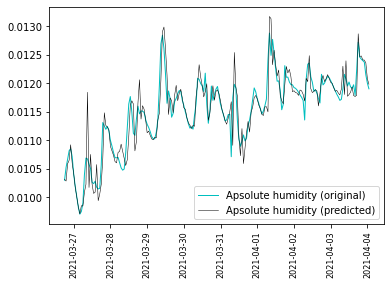

In [20]:
plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][100:300],eval_df[eval_df['h']== 't+1']['actual'][100:300],color='c',LineWidth=1,label='Apsolute humidity (original)')
plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][100:300],eval_df[eval_df['h']== 't+1']['prediction'][100:300],color='k',LineWidth=0.5,label='Apsolute humidity (predicted)')
#plt.plot(df['epoch_t'],df['temp_clean'],color='c',LineWidth=1.5,label='T_simplified')
#plt.xlim(df['epoch_t'][0],df['epoch_t'][-1])
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.savefig('page.pdf',
            dpi=600,
            orientation='landscape')

<ipython-input-22-71099dc3c9b9>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][250:350],eval_df[eval_df['h']== 't+1']['actual'][250:350],color='c',LineWidth=1.5,label='Apsolute humidity (original)')
<ipython-input-22-71099dc3c9b9>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][250:350],eval_df[eval_df['h']== 't+1']['prediction'][250:350],color='k',linestyle = 'dashed', LineWidth=1.5,label='Apsolute humidity (predicted)')


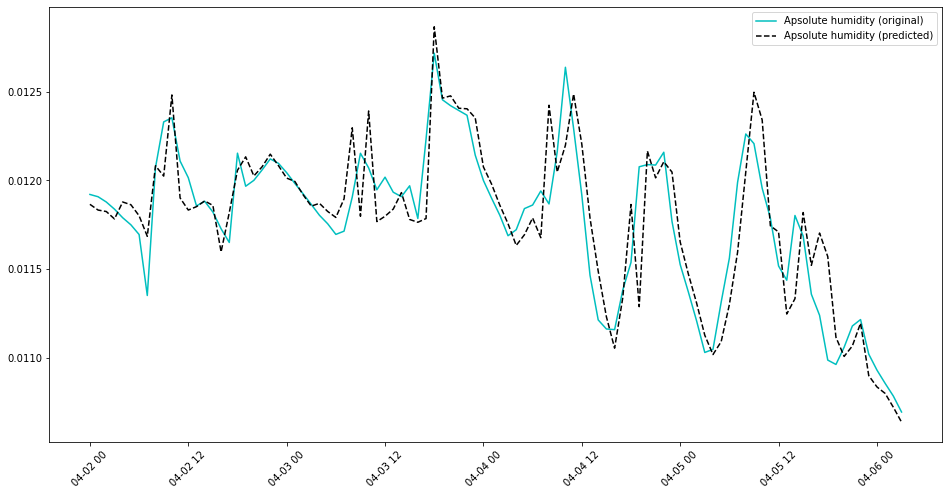

In [22]:
plt.rcParams['figure.figsize']=[16,8]
plt.rcParams.update({'font.size':10})
plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][250:350],eval_df[eval_df['h']== 't+1']['actual'][250:350],color='c',LineWidth=1.5,label='Apsolute humidity (original)')
plt.plot(eval_df[eval_df['h']== 't+1']['timestamp'][250:350],eval_df[eval_df['h']== 't+1']['prediction'][250:350],color='k',linestyle = 'dashed', LineWidth=1.5,label='Apsolute humidity (predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('page_ts.pdf',
            dpi=600,
            orientation='landscape')